## Configure tesseract

In [1]:
import pytesseract
print(pytesseract.get_tesseract_version())
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

5.5.0.20241111


## โหลดรูปเบื้องต้น

In [2]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_V6")
output_folder.mkdir(exist_ok=True)

image = cv2.imread("../data/test_images/transcript/img-3.png")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# จำกัด noise
denoised = cv2.bilateralFilter(image, 50, 100, 100)
cv2.imwrite(f"{output_folder}/transcript_denoised.png", denoised)

gray_img = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

# สำหรับภาพที่แสงสม่ำเสมอ
binary_mean = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=41, 
    C=20
)

# สำหรับภาพที่แสงไม่สม่ำเสมอ
binary_gaussian = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=41, 
    C=20
)

# ใช้ Otsu Thresholding
_, binary_otsu = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

cv2.imwrite(f"{output_folder}/transcript.png", image)
cv2.imwrite(f"{output_folder}/transcript_gray.png", gray_img)
cv2.imwrite(f"{output_folder}/transcript_binary_g.png", binary_gaussian)
cv2.imwrite(f"{output_folder}/transcript_binary_m.png", binary_mean)
cv2.imwrite(f"{output_folder}/transcript_otsu.png", binary_otsu)

True

## แยกตารางกับข้อมูลส่วนบน

In [3]:
# แยกตาราง
original_img = image
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_gaussian, connectivity=8)
areas = [stat[4] for stat in stats]  # ดึงค่า area
sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
second_max_area = sorted_areas[1]  # ค่าอันดับ 2
second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม

table_position = stats[second_max_area_index]
x, y, w, h, area = table_position
table_img = binary_gaussian[y:y+h, x:x+w]
cv2.imwrite(f"{output_folder}/table.png", table_img)

# แยกประวัติส่วนตัว
student_info_img = binary_gaussian[:y, :]
student_info_gray = gray_img[:y, :]
student_info_color = original_img[:y, :]
cv2.imwrite(f"{output_folder}/student_info_color.png", student_info_color)

# หารูปโปรไฟล์
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(student_info_img, connectivity=8)
areas = [stat[4] for stat in stats]  # ดึงค่า area
sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
second_max_area = sorted_areas[1]  # ค่าอันดับ 2
second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม

profile_position = stats[second_max_area_index]
x, y, w, h, area = profile_position
profile_img = student_info_img[y:y+h, x:x+w]

# ประวัติส่วนตัวที่เอารูปโปรไฟล์ออก
studentInfo_no_profile_img = student_info_img[:, :x-10]
studentInfo_no_gray = student_info_gray[:, :x-10]
cv2.imwrite(f"{output_folder}/studentInfo_no.png", studentInfo_no_profile_img)
cv2.imwrite(f"{output_folder}/studentInfo_no_gray.png", studentInfo_no_gray)

True

## จับกลุ่มข้อความใน record

In [4]:
def detect_text_group(dilalated_image, binary_image):

    text_group_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilalated_image, connectivity=8)

    # กรองข้อมูล Background และจัดเรียงจากบนไปลงล่าง (ตามค่า y)
    char_stats = stats[1:]  # ข้าม Background (index 0)
    #sorted_indices = np.argsort(char_stats[:, 1])  # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
    #sorted_stats = char_stats[sorted_indices]

    sorted_indices = np.lexsort((char_stats[:, 0], char_stats[:, 1]))  # (x, y)
    sorted_stats = char_stats[sorted_indices]

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00

    for idx, stats in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stats

        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(binary_image.shape[1] - x_exp, w_exp)
        h_exp = min(binary_image.shape[0] - y_exp, h_exp)

        if w >= 90 and h >= 20:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
            text_group_images.append(cca_img)
            cv2.imwrite(f"{output_folder}/studentInfo/cca_{idx}.jpg", cca_img)
            cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

    return text_group_images

kernel = np.ones((6, 80), np.uint8)
lines_studentInfo = cv2.dilate(studentInfo_no_profile_img, kernel, iterations=1)
cv2.imwrite(f"{output_folder}/studentInfo/find_lines.png", lines_studentInfo)

text_group_studentInfo_images = detect_text_group(lines_studentInfo, studentInfo_no_profile_img)


In [5]:
custom_config = r'--oem 3 --psm 7'  # ใช้ OCR Engine Mode และ Page Segmentation Mode ที่เหมาะสม

studentInfo_text_box = []
for idx, text_img in enumerate(text_group_studentInfo_images):
    text = pytesseract.image_to_string(text_img, config=custom_config, lang='tha')
    #plt.figure(figsize=(5, 5))
    #plt.imshow(text_img)
    #plt.imshow(text_img, cmap="gray")
    #plt.title(f"dilated_lines")
    plt.show()
    text_cleaned = text.replace("\n", "")  # ลบ \n ออก
    studentInfo_text_box.append(text_cleaned)
    print(text_cleaned)



รบ.1 ปวส. เล“
ระเบียนแสดงผลการเรียนตามหลักสูตรประกาศนียบัตรวิชาชีพชั้นสูง (ปวส.) พุทธศักราช 2563
ชื่อสถานศึกษา วิทยาลัยเทคนิคเชียงราย
รหัสสถานศึกษา 1357016101
จังหวัด เชียงราย
สถานศึกษาเดิม วิทยาลัยเทคนิคเชียงราย
จังหวัด เชียงราย
รหัสประจําตัว 63301280021
ชื่อ - ชื่อสกุล นายอัมรินทร์ ธรรมกาศ
ระดับการศึกษาที่จบ ประกาศนียบัตรวิชาชีพ
เชื้อซาติ ไทย สัญชาติ ไทย ศาสนา พุทธ
ปีการศึกษาที่จบ 2562
เข้าศึกษาเมื่อ 1 กรกฎาคม 2563
วัน เดือน ปีเกิด 1 สิงหาคม 2544 .
หน่วยกิตที่รับโอน -
เลขประจําตัวประชาชน 1 5799 00931 89 ศุ
ชื่อบิดา      นายจํารัส ธรรมกาศ
หน่วยกิตที่เรียน 103
ชื่อมารดา นางสาวกนกพัชร อื่นคํา
หน่วยกิตที่ได้           83
ระดับคะแนนเฉลี่ยสะสม 3.89
ประเภทวิชา อุตสาหกรรม
ผ่านเกณฑ์การประเมินมาตรฐานวิชาชีพเมื่อ 15 มีนาคม 2565
สาขาวิชา เทคโนโลยีคอมพิวเตอร์
สําเร็จการศึกษาเมื่อ 28 มีนาคม 2565
สาขางาน คอมพิวเตอร์ระบบเครื่อข่าย


## แบ่งส่วนตาราง

In [6]:
def table_cell_detection(table_img):
    # ใช้ Morphological Operations เพื่อตรวจจับเส้น
    #แนวนอน (Rows)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    horizontal_lines = cv2.morphologyEx(table_img, cv2.MORPH_OPEN, horizontal_kernel)

    #แนวตั้ง (Columns)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
    vertical_lines = cv2.morphologyEx(table_img, cv2.MORPH_OPEN, vertical_kernel)

    # รวมเส้น
    table_structure = cv2.add(horizontal_lines, vertical_lines)

    # Combine lines
    combined_lines = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0)

    # Dilate to connect broken lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_lines = cv2.dilate(combined_lines, kernel, iterations=1)

   # plt.figure(figsize=(15, 15))
    #plt.imshow(dilated_lines, cmap="gray")
    #plt.title(f"dilated_lines")
    #plt.show()

    # Find contours
    contours, _ = cv2.findContours(dilated_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return contours

table_cell_contours = table_cell_detection(table_img)

# ฟังก์ชันสำหรับดึงค่า y (แนวตั้ง) สำหรับการจัดเรียงตามแถว
def get_y_position(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return y

# ฟังก์ชันสำหรับดึงค่า x (แนวนอน) สำหรับการจัดเรียงตามคอลัมน์
def get_x_position(cell):
    x, y, w, h = cell
    return x

# จัดเรียง contours ตามตำแหน่ง y (แนวตั้ง) เพื่อแยกแถว
sorted_contours = sorted(table_cell_contours, key=get_y_position)

# แยกแถว
rows = []
current_row = []
previous_y = -1
for ctr in sorted_contours:
    x, y, w, h = cv2.boundingRect(ctr)
    if(w < 30 and h < 30):
        continue
    if previous_y == -1 or abs(y - previous_y) < 10:  # Same row threshold
        current_row.append((x, y, w, h))
    else:
        # จัดเรียงคอลัมน์ในแถวปัจจุบันตามตำแหน่ง x
        rows.append(sorted(current_row, key=get_x_position))
        current_row = [(x, y, w, h)]
    previous_y = y

# เพิ่มแถวสุดท้าย
if current_row:
    rows.append(sorted(current_row, key=get_x_position))

cell_images = []
for row_index, row in enumerate(rows[1:2]):
    for col_index, cell in enumerate(row):
        x, y, w, h = cell
        #cell_image = table_img[y:y+h, x:x+w]
        cell_img = table_img[y+4:y+h-4, x+4:x+w-4]

        # ตัดขอบออก 5%
        #margin_x = int(w * 0.05)  # คำนวณขอบ 2% ของความกว้าง
        #margin_y = int(h * 0.02)  # คำนวณขอบ 2% ของความสูง
        #cropped_cell_image = cell_image[margin_y:h-margin_y, margin_x:w-margin_x]

        cell_images.append(cell_img)
        print(col_index)
        cv2.imwrite(f"{output_folder}/table/Row_{row_index}_Col_{col_index}.png", cell_img)



0
1
2
3
4
5
6
7
8
9


### จับกลุ่มข้อความในตาราง

In [47]:
def detect_text_group_in_cell(dilalated_image, binary_image, mode, calculate_line_stats=None):
    rgb_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

    text_group_images = []
    
    if(mode == 1):
        # ใช้ Connected Component Analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilalated_image, connectivity=8)

        # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
        char_stats = stats[1:]  # ข้าม Background (index 0)
        sorted_indices = np.argsort(char_stats[:, 1])  # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
        sorted_stats = char_stats[sorted_indices]

        # ใช้ Boolean Indexing เพื่อเอา noise ออก 
        sorted_stats = sorted_stats[sorted_stats[:, 4] >= 100]

        calculate_line_stats = []
        
        #หาช่องระยะห่างระหว่างบรรทัดเพื่อนนำไปใช้กับ col ชื่อวิชา
        for idx_stat, stat in enumerate(sorted_stats):
            if idx_stat == (len(sorted_stats)-1):
                print("เข้าเงื่อน",idx_stat)
                x, y, w, h, area = stat
                new_y = round(y-(h/2))
                new_h = round(h+h)
                calculate_line_stats.append([x, new_y, w, new_h, area])
            else:
                #print("index: ",idx_stat)
                current_stat = stat
                next_stat = sorted_stats[idx_stat+1]

                distance = next_stat[1] - current_stat[1]
                line_spacing = distance/current_stat[3]

                if line_spacing > 3 and line_spacing < 7: # เป็นชื่อวิชาที่มีความยาวมากกว่า 1 บรรทัด
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*2.5))
                    calculate_line_stats.append([x, new_y, w, new_h, area])
                elif line_spacing > 7:
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+h)
                    calculate_line_stats.append([x, new_y, w, new_h, area])
                else:
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+h)
                    calculate_line_stats.append([x, new_y, w, new_h, area])

        calculate_line_stats = np.array(calculate_line_stats)
        #print(idx_stat, current_stat)
        #print(distance, line_spacing)

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00
    text_stats = sorted_stats if mode == 1 else calculate_line_stats
    
    for idx, stats in enumerate(text_stats):  # เริ่มจาก 1 เพราะ 0 คือ background

        x, y, w, h, area = stats

        if area >= 100:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            if mode == 1:
                cca_img = binary_image[y:y+h, x:x+w]
            else:
                cca_img = binary_image[y:y+h, :]
            text_group_images.append(cca_img)
            #cv2.imwrite(f"{output_folder}/table/cca_{idx}.jpg", cca_img)

            # หาขนาดของภาพ (ความกว้างและความสูง)
            image_height, image_width, _ = rgb_image.shape  # ได้ค่า (สูง, กว้าง, ช่องสี)
            cv2.rectangle(rgb_image, (x, y), (image_width, y + h), (0, 255, 0), 1)
    
    if mode == 1:
        return text_group_images, calculate_line_stats, rgb_image
    else:
        return text_group_images, rgb_image

cell_text_group_images = []
for idx_cell, cell_img in enumerate(cell_images):
    kernel = np.ones((5, 15), np.uint8)
    lines_cell = cv2.dilate(cell_img, kernel, iterations=1)
    cv2.imwrite(f"{output_folder}/table/text_group/cell_{idx_cell}.png", lines_cell)
    print("cell_img :", idx_cell)

    if idx_cell == 0 or idx_cell == 5:
        print("mode:", 1)
        text_group_cells, calculate_line_stats, cca_img = detect_text_group_in_cell(lines_cell, cell_img, 1)
    else:
        print("mode:", 2)
        text_group_cells, cca_img = detect_text_group_in_cell(lines_cell, cell_img, 2, calculate_line_stats)

    #text_group_cells, cca_img = detect_text_group_in_cell(lines_cell, cell_img, 1)
    cv2.imwrite(f"{output_folder}/table/text_group/cca_{idx_cell}.jpg", cca_img)
    cell_text_group_images.append(text_group_cells)

cell_img : 0
mode: 1
เข้าเงื่อน 23
cell_img : 1
mode: 2
cell_img : 2
mode: 2
cell_img : 3
mode: 2
cell_img : 4
mode: 2
cell_img : 5
mode: 1
เข้าเงื่อน 18
cell_img : 6
mode: 2
cell_img : 7
mode: 2
cell_img : 8
mode: 2
cell_img : 9
mode: 2


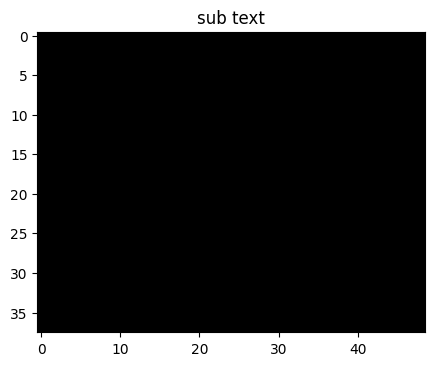

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
ภาพเป็นสีดำทั้งหมด


In [48]:

plt.figure(figsize=(5,5))
plt.imshow(cell_text_group_images[2][10], cmap="gray")
plt.title(f"sub text")
plt.show()
print(cell_text_group_images[2][10])

# เช็คว่าภาพเป็นสีดำทั้งหมดหรือไม่
if not np.any(cell_text_group_images[2][10]):  # ถ้าค่าพิกเซลทั้งหมดเป็น 0 (ดำสนิท)
    print("ภาพเป็นสีดำทั้งหมด")
else:
    print("ภาพมีบางส่วนที่ไม่ใช่สีดำ")


### จับข้อความย่อยในกลุ่มข้อความของ cell ตาราง

In [52]:
def detect_text_in_group(binary_image):
    kernel = np.ones((6, 6), np.uint8)
    dummy_image = cv2.dilate(binary_image, kernel, iterations=3)

    '''
    plt.figure(figsize=(5,5))
    plt.imshow(dummy_image, cmap="gray")
    plt.title(f"sub text")
    plt.show()
    '''
    sub_text_images = []

    # เช็คว่าภาพเป็นสีดำทั้งหมดหรือไม่
    if not np.any(binary_image):  # ถ้าค่าพิกเซลทั้งหมดเป็น 0 (ดำสนิท)
        print("ภาพเป็นสีดำทั้งหมด")
        sub_text_images.append(binary_image)
        return sub_text_images 
    else:
        # ใช้ Connected Component Analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)

        # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
        char_stats = stats[1:]  # ข้าม Background (index 0)
        sorted_indices = np.argsort(char_stats[:, 0])  # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
        sorted_stats = char_stats[sorted_indices]

        expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
        reduce_size = 0.00
        #for idx, i in enumerate(range(1, num_labels)):  # เริ่มจาก 1 เพราะ 0 คือ background
        for idx, stats in enumerate(sorted_stats):
            #x, y, w, h, area = stats[i]
            x, y, w, h, area = stats
            x_exp = int(x - (expand_ratio-reduce_size) * w)
            y_exp = int(y - (expand_ratio) * h)
            w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
            h_exp = int(h + 2 * (expand_ratio) * h)

            # ตรวจสอบไม่ให้เกินขอบภาพ
            x_exp = max(0, x_exp)
            y_exp = max(0, y_exp)
            w_exp = min(binary_image.shape[1] - x_exp, w_exp)
            h_exp = min(binary_image.shape[0] - y_exp, h_exp)

            cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
            sub_text_images.append(cca_img)
            #cv2.imwrite(f"../data/output_images/output/text_sub/cca_{idx}.jpg", cca_img)
            #cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

        return sub_text_images 

cell_text_group_sub_images = []
for idx_cell, cell in enumerate(cell_text_group_images):
    #print("cell ที่ :", idx_cell+1)

    sub_text_cell_images = []
    for idx_text, text_img in enumerate(cell):
        #print("  ข้อความที่ :", idx_text+1)
        sub_text_cell_images.append(detect_text_in_group(text_img))

    cell_text_group_sub_images.append(sub_text_cell_images)



ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด


### จับตัวอักษร

In [54]:
custom_config = r'--oem 3 --psm 7'

def predict_text_in_cell(text_group_sub_images):
    text_box = []
    for idx_group, text_group in enumerate(text_group_sub_images):
        for idx_sub, sub_text in enumerate(text_group):
            #plt.figure(figsize=(2, 2))
            #plt.imshow(sub_text, cmap="gray")
            #plt.title(f"dilated_lines")
            if not np.any(sub_text):
                print("เข้าเงื่อนไข")
                text = "-"
                '''
                plt.figure(figsize=(5,5))
                plt.imshow(sub_text, cmap="gray")
                plt.title(f"sub text")
                plt.show()
                '''
            else:
                text = pytesseract.image_to_string(sub_text, config=custom_config, lang='tha')
            text_cleaned = text.replace("\n", "")  # ลบ \n ออก
            text_box.append(text_cleaned)
            #print(text_cleaned)

    return text_box

cell_subject_code = cell_text_group_sub_images[0]
cell_subject_name = cell_text_group_sub_images[1]
cell_credit = cell_text_group_sub_images[2]
cell_academic_results = cell_text_group_sub_images[3]
cell_subject_code_2 = cell_text_group_sub_images[5]
cell_subject_name_2 = cell_text_group_sub_images[6]
cell_credit_2 = cell_text_group_sub_images[7]
cell_academic_results_2 = cell_text_group_sub_images[8]

text_box_subject_code = predict_text_in_cell(cell_subject_code)
text_box_subject_name = predict_text_in_cell(cell_subject_name)
text_box_credit = predict_text_in_cell(cell_credit)
text_box_academic_results = predict_text_in_cell(cell_academic_results)
text_box_subject_code_2 = predict_text_in_cell(cell_subject_code_2)
text_box_subject_name_2 = predict_text_in_cell(cell_subject_name_2)
text_box_credit_2 = predict_text_in_cell(cell_credit_2)
text_box_academic_results_2 = predict_text_in_cell(cell_academic_results_2)




เข้าเงื่อนไข
เข้าเงื่อนไข
เข้าเงื่อนไข
เข้าเงื่อนไข


In [65]:
def show_information(array):
    for idx, data in enumerate(array):
        print(data)

#show_information(text_box_subject_code)
show_information(text_box_subject_name)
#show_information(text_box_credit)
#show_information(text_box_academic_results)
#show_information(text_box_subject_code_2)
#show_information(text_box_subject_name_2)
#show_information(text_box_credit_2)
#show_information(text_box_academic_results_2)

แคลคูลัส 1
งานไฟฟ้าและอิเล็กทรอนิกส์
การเขียนแบบอิเล็กทรอนิกส์ด้วยคอมพิวเตอร์
อุปกรณ์อิเล็กทรอนิกส์และวงจร
วงจรพัลส์และดิจิทัลเทคนิค
ระบบคอมพิวเตอร์และอุปกรณ์ต่อพ่วง
ไมโครโพรเชสเซอร์และไมโครคอนโทรลเลอร์
การเขียนโปรแกรมคอมพิวเตอร์
เครือข่ายคอมพิวเตอร์
ระบบฐานข้อมูลเบื้องต้น
กิจกรรมองค์การวิชาชีพ 1
ทักษะภาษาไทยเชิงวิชาซีพ
ภาษาอังกฤษเพื่อการสื่อสาร
วิทยาศาสตร์งานไฟฟ้า อิเล็กทรอนิกส์
การออกกําลังกายเพื่อสุขภาพ
ลีลาศเพื่อพัฒนาสุขภาพและบุคลิกภาพ
นันทนาการเพื่อพัฒนาคุณภาพชีวิต
กฎหมายทั่วไปเกี่ยวกับงานอาชีพ
เทคโนโลยีสารสนเทศเพื่อการจัดการอาชีพ
การใช้โปรแกรมคอมพิวเตอร์กราฟิก
เทคโนโลยีอิเล็กทรอนิกส์
ระบบปฏิบัติการ
การออกแบบและพัฒนาเว็บไซต์
กิจกรรมองค์การวิชาชีพ 2


In [59]:
combined_list = list(zip(cell_subject_code, cell_subject_name, cell_credit, cell_academic_results))

In [62]:
print(cell_subject_code)

[[array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)], [array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)], [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)], [array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0, 255, ...,   0,   0,   0],
   